## Fantasy Premier League Points Predictor 

The project aims at predicting which player should be drafted in a team based on the predicted points scored by him in the upcoming week. The data is scraped from Fantasy Premier League's website after each game week. We utilize N-1 weeks worth of data. Extra features are also created to perform further analysis on how players have been performing over the season and notice trends in performances. 

For future steps we plan to move to a regression based model in order to provide specific results.

**Assumptions**- Even though we can achieve high accuracy with the model, we cannot neglect the fact that this is a sport and the variation is always high. We cannot account for human behaviour for example a player having a bad day because of personal reasons. We do not take into account the player's relationship with the manager, we mention this because manager has the right t0 bench or not play a particular player. We also do not account for injuries **yet**


**Importing Main Libraries**

In [1]:
#importing Important libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import datetime
import sqlite3
 
%matplotlib inline

#### Loading Data

**After importing the necessary libraries, we will establish a connection with the local sqllite database. The name of database is 'fpl' and it contains a single table by the name 'gw'. Once we establish the connection we can execute queries just like we do in SQL environment**

In [100]:
#connection to .db file
conn = sqlite3.connect("/Users/anmolsabharwal/Desktop/fpl.db")
cur = conn.cursor()
gws = pd.read_sql_query("SELECT * FROM gw", conn)


In [3]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

#### Data Preprocessing 
**For the ease of use and consistency, convert the columns to appropriate data type.**

In [4]:
#converting the datatypes of columns
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':int,
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        # 'team_a_score':int, 'team_h_score':int,
        'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int,'gw':int})

**Once we have the columns with the correct data type we check for any NULL values present in the dataset. To make things easier, we use the Seaborn libarary to plot the heatmap. Since it returns a complete black heatmap, it means there are no missing values**

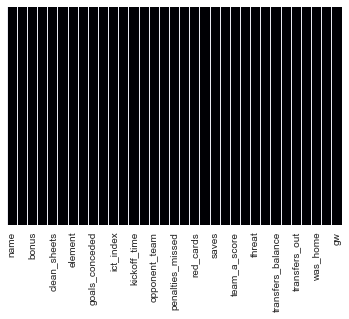

In [5]:
# cheking for null values
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

**The names provided in the dataset are strings, just to make things easier we are going to assign unique ID's based on names.**

In [6]:
#assigning id to each specific player
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


**To reduce noice in the data, we will remove all those players who havent played a match and we do this by using a filter on 'minutes' column. We chose the minutes column instead of points because a player can have 0 points even after playing for 90 minutes**

In [7]:
gws= gws[gws['minutes'] > 0] 


**This function decides the difficulty of a particular fixture based on the positiion of a team in a table. Teams in the top half of the table will have highest fixture difficulty ratio while the teams in the bottom half will have lower fixture difficulty ratio.**

In [8]:
# a function to decide the fixture difficulty ratio based on the position of the opponent team
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [9]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [10]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


**The matches usually take place at different times of the day. We first extracted the hour from the datetime and then divided it into 3 categories to see if it has any effect on the perfomance of a player**

In [11]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [12]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


In [13]:
#divind the kickoff time into 3 categories 
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [14]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,...,0.0,1,0,0,0,60,TRUE,0,1,2
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,...,23.0,2,0,0,0,80,TRUE,0,1,5
5,Abel Hern·ndez,1,0,10,0,12.2,163,4,1,0,...,30.0,5,0,0,0,60,TRUE,0,1,13
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,...,45.0,8,0,0,0,45,TRUE,0,1,29
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,...,9.0,2,0,0,0,45,TRUE,0,1,17
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,...,0.0,1,0,0,0,45,TRUE,1,1,19
10,Adam Lallana,1,2,33,0,33.7,205,8,3,1,...,57.0,11,0,0,0,70,FALSE,1,1,21
13,Adam Smith,0,0,23,0,4.3,34,9,3,1,...,27.0,7,0,0,0,45,TRUE,0,1,26
14,AdlËne GuÈdioura,0,0,7,0,13.7,415,7,1,0,...,3.0,1,0,0,0,45,FALSE,1,1,34
15,Adnan Januzaj,0,0,4,0,0.3,261,5,1,0,...,0.0,1,0,0,0,55,FALSE,0,1,35


**While exploring different variables that effect the performance of a player we wanted to focus on how he performs at home matches and away matches. In order to that, we change the initial boolean 'True' and 'False' values to 'Home' and 'Away'. After that we performed one hot encding to get different columns for both Home and Away.**

In [15]:
# setting up the 'was_home' column to create binary attributes
def was_home(a):
  a=a.upper()
  if a=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [16]:
gws['home']=gws['was_home'].apply(was_home)

**Feature engineered variables based on Home and away performances of a player for further analysis**

In [17]:
gws['Away Points'] = np.where(gws['home'] == 'Home', gws['total_points'] * 0,gws['total_points'])
gws['Home Points'] = np.where(gws['home'] == 'Away', gws['total_points'] * 0,gws['total_points'])

gws['Away Influence'] = np.where(gws['home'] == 'Home', gws['influence'] * 0,gws['influence'])
gws['Home Influence'] = np.where(gws['home'] == 'Away', gws['influence'] * 0,gws['influence'])

gws['Away Goals'] = np.where(gws['home'] == 'Home', gws['goals_scored'] * 0,gws['goals_scored'])
gws['Home Goals'] = np.where(gws['home'] == 'Away', gws['goals_scored'] * 0,gws['goals_scored'])

gws['Away Saves'] = np.where(gws['home'] == 'Home', gws['saves'] * 0,gws['saves'])
gws['Home Saves'] = np.where(gws['home'] == 'Away', gws['saves'] * 0,gws['saves'])

gws['Away Creativity'] = np.where(gws['home'] == 'Home', gws['creativity'] * 0,gws['creativity'])
gws['Home Creativity'] = np.where(gws['home'] == 'Away', gws['creativity'] * 0,gws['creativity'])

gws['Away ICT'] = np.where(gws['home'] == 'Home', gws['ict_index'] * 0,gws['ict_index'])
gws['Home ICT'] = np.where(gws['home'] == 'Away', gws['ict_index'] * 0,gws['ict_index'])

gws['Away Bonus'] = np.where(gws['home'] == 'Home', gws['bonus'] * 0,gws['bonus'])
gws['Home Bonus'] = np.where(gws['home'] == 'Away', gws['bonus'] * 0,gws['bonus'])

gws['Away Clean Sheets'] = np.where(gws['home'] == 'Home', gws['clean_sheets'] * 0,gws['clean_sheets'])
gws['Home Clean Sheets'] = np.where(gws['home'] == 'Away', gws['clean_sheets'] * 0,gws['clean_sheets'])

gws['Away Penalties Saved'] = np.where(gws['home'] == 'Home', gws['penalties_saved'] * 0,gws['penalties_saved'])
gws['Home Penalties Saved'] = np.where(gws['home'] == 'Away', gws['penalties_saved'] * 0,gws['penalties_saved'])

gws['Away Goals Conceded'] = np.where(gws['home'] == 'Home', gws['goals_conceded'] * 0,gws['goals_conceded'])
gws['Home Goals Conceded'] = np.where(gws['home'] == 'Away', gws['goals_conceded'] * 0,gws['goals_conceded'])

gws['Away Assists'] = np.where(gws['home'] == 'Home', gws['assists'] * 0,gws['assists'])
gws['Home Assists'] = np.where(gws['home'] == 'Away', gws['assists'] * 0,gws['assists'])

gws.head(20)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,...,0,0,0,0,0,0,0,3,0,0
5,Abel Hern·ndez,1,0,10,0,12.2,163,4,1,0,...,0,0,0,0,0,0,0,1,0,1
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,...,0,2,0,0,0,0,0,1,0,0
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,...,0,0,0,0,0,0,0,1,0,0
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,...,0,0,0,0,0,0,0,1,0,0
10,Adam Lallana,1,2,33,0,33.7,205,8,3,1,...,2,0,0,0,0,0,3,0,1,0
13,Adam Smith,0,0,23,0,4.3,34,9,3,1,...,0,0,0,0,0,0,0,3,0,0
14,AdlËne GuÈdioura,0,0,7,0,13.7,415,7,1,0,...,0,0,0,0,0,0,1,0,0,0
15,Adnan Januzaj,0,0,4,0,0.3,261,5,1,0,...,0,0,0,0,0,0,1,0,0,0


**Dropping columns that are not required**


In [18]:
#dropping columns that are not required
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

**The value of a player is the most important aspect of the game apart from the points. We are only given a budget on 100Mn to buy 15 players. The values in the original dataset were on a different scale, in order for it to makes sense we have adjusted the scale.**

In [19]:
gws['value']=gws['value']*0.1



**The algorithm makes a decision of a player being drafter or not purely on the basis of points for now. In the original dataset we were given points in order for it to be converted into a classifacaion problem we divided the points into two categories-<br></br>
1)Less than 7(Player will not be drafted)<br></br>
2)Greater than 7(Player will be drafted)**

In [20]:
# a fucntion to put the points into the bins. This is where the business problem is convereted from a regression to a classification problem
def points(x):
  if x<8:
    return 0
  # elif x==2:
  #   return 2
  # elif x>2 and x<7:
  #   return 3
  else:
    return 1


In [21]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()
gws1.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,...,0,0,0,0,0,0,0,0,0,0
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,...,0,0,0,0,0,0,3,0,0,0
5,Abel Hern·ndez,1,0,10,0,12.2,1,0,5.7,14.4,...,0,0,0,0,0,0,1,0,1,0
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,...,2,0,0,0,0,0,1,0,0,1
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,...,0,0,0,0,0,0,1,0,0,0


**Distribution of each class of the dependent variable. This clearly shows there is a class imbalance which is obvious because we are trying to seperate and predict exceptional performances**

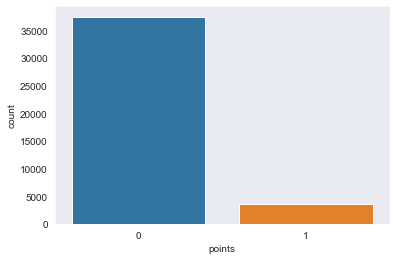

In [22]:
sns.countplot(gws1['points'])

**We need historical data to create variables so we try and make the algorithm understand hwo the player has been performing over the past few weeks to notice a pattern. This is called lags where the value lags for a week and is porjected onto next week**


In [23]:
#creating lags for different attributes

gws1['Last_Week_Points'] = gws1.groupby(['id'])['total_points'].shift().astype(float)
# gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
# gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
# gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
# gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
# gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
# gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
# gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
# gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
# gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
# gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
# gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
# gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
# gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
# gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
# gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
# gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
# gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift().astype(float)
# gws1['Last_2_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(2).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
# gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift().astype(float)
# gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift().astype(float)
# gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Last_Week_Creativity,Last_Week_FDR,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Abel Hern·ndez,1,0,10,0,12.2,1,0,5.7,14.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Francis Coquelin,0,0,3,0,13.4,4,0,1.4,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,Fraser Forster,0,0,7,0,0.0,1,0,0.2,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,Gareth Barry,0,0,13,0,21.8,1,0,3.3,11.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,Gareth McAuley,0,1,24,1,0.0,0,0,2.1,21.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Creating binary attributes for was_home**


In [24]:
#creating binary attributes for was_home

home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Last_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_Week_Own_Goals,Last_Week_Penalties_Missed,Last_Week_Penalties_Saved,Last_Week_Red_Cards,Last_Week_Saves,Last_Week_Yellow_Cards,Away,Home
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
5,Abel Hern·ndez,1,0,10,0,12.2,1,0,5.7,14.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


**Calculating the correlation of the different variables with the dependent variable. This step was important to see what type of variables affect the dependent variable the most. Based on these results we were encourages to feature engineer variables on those attributes that effect dependent variable the most**


In [25]:
#calculating the correaltion of the different variables with the dependent variable
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                  1.000000
bps                           0.854537
bonus                         0.778032
points                        0.767668
influence                     0.735786
goals_scored                  0.683782
Home Points                   0.649007
ict_index                     0.621242
Home Bonus                    0.579419
Home Goals                    0.513870
Away Points                   0.502919
Home Influence                0.500616
clean_sheets                  0.488927
Away Bonus                    0.488762
Away Goals                    0.430229
assists                       0.424002
Home ICT                      0.412565
threat                        0.401019
Home Clean Sheets             0.367483
Away Influence                0.327445
Home Assists                  0.324475
minutes                       0.306286
Away ICT                      0.278403
Away Clean Sheets             0.273182
creativity                    0.262837
Away Assists             

**This is where magic happens, we have feature engineered variables based on a number of factors like per 90 min, home and away statistics. This is done to make the algorithm understand different patterns in the data. We will also utilize these variables to create visualization.**

In [26]:
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =gws1.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =(gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =(gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90).astype(float)
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =(gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =(gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =(gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
gws1["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['Home Influence'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =gws1.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum().shift(1).astype(float)
gws1["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
gws1["Save per min"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =gws1.groupby('id',as_index=False)['saves'].rolling(window=window).sum().shift(1).astype(float)
gws1["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =gws1.groupby('id',as_index=False)['minutes'].rolling(window=window).sum().shift(1).astype(float)
gws1["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum().shift(1).astype(float)
gws1["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum().shift(1).astype(float)
gws1["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =gws1.groupby('id',as_index=False)['bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =gws1.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum().shift(1).astype(float)
gws1["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum().shift(1).astype(float)
gws1['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum().shift(1).astype(float)
gws1["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =gws1.groupby('id',as_index=False)['assists'].rolling(window=window).sum().shift(1).astype(float)
gws1["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =gws1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/gws1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# gws1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
gws1["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =gws1.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
gws1["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =gws1.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
gws1["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum().shift(1).astype(float)
gws1["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =gws1.groupby('id',as_index=False)['minutes'].expanding().sum()/gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
gws1["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =gws1.groupby('id',as_index=False)['total_points'].rolling(window=window).sum().shift(1).astype(float)
gws1["Points Form"] = tp.reset_index(level=0, drop=True)

pm =gws1.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum().shift(1).astype(float)
gws1["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =gws1.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum().shift(1).astype(float)
gws1["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =gws1.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum().shift(1).astype(float)
gws1["Red Cards Form"] = rc.reset_index(level=0, drop=True)



**A function to capture the goal scoring streak of a player. Basically the counter will be set to '1' whenever a player scores a goal and keep on adding +1 to it as long as the player keeps scoring goals in consecutive matches. If the player fails to score a goal in a match then the counter will be set to 0 again.**





In [27]:
# a function to capture the goal scoring streak of a player
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['goals_scored'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df


In [28]:
gws1=gws1.groupby('id').apply(f)


**Following the same concept expalined above, we will capture the clean sheet streak of a player**



In [29]:
def f2(df):
    df['csstreak'] = (df['clean_sheets'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['clean_sheets'] == 0, 'cumsum'] = df['csstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Clean Sheet Streak'] = df['csstreak'] - df['cumsum']
    df.drop(['csstreak', 'cumsum'], axis=1, inplace=True)
    df['Clean Sheet Streak']=df['Clean Sheet Streak'].shift(1)
    return df


In [30]:
gws1=gws1.groupby('id').apply(f2)

**A function to capture the penalty Saving streak of a player. These functions are important to analyze the patterns**



In [31]:
def f3(df):
    df['psstreak'] = (df['penalties_saved'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['penalties_saved'] == 0, 'cumsum'] = df['psstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Penalty Save Streak'] = df['psstreak'] - df['cumsum']
    df.drop(['psstreak', 'cumsum'], axis=1, inplace=True)
    df['Penalty Save Streak']=df['Penalty Save Streak'].shift(1)
    return df

In [32]:
gws1=gws1.groupby('id').apply(f3)

**Dropping all the NAn, inf values created because of feature engineering. This is an important step because the algorithm is goign to throw an error in there are an Nan's or inf's present in the datastet**


In [33]:
#dropping all the NAn, inf values created because of feature engineering
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(200)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Goal Streak,Clean Sheet Streak,Penalty Save Streak
2928,Aaron Ramsey,0,0,0,0,12.5,1,0,5.9,8.8,...,3.0,4.0,46.200000,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2934,Adam Clayton,0,0,13,1,6.3,0,0,1.7,10.0,...,2.0,5.0,104.400000,4.0,0.0,2.0,0.0,0.0,0.0,0.0
2936,Adam Forshaw,0,0,24,1,34.3,0,0,6.1,18.0,...,2.0,5.0,103.400000,9.0,0.0,1.0,0.0,0.0,0.0,0.0
2945,Ahmed Elmohamady,0,0,15,0,1.5,1,0,2.2,18.2,...,3.0,7.0,67.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2946,Ahmed Musa,0,0,3,0,0.8,1,0,0.9,0.6,...,2.0,5.0,46.166667,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2952,Aleksandar Kolarov,0,0,15,0,13.3,3,0,2.7,13.4,...,2.0,4.0,77.142857,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2954,Alexis S·nchez,1,3,76,0,58.0,1,3,25.3,129.6,...,6.0,8.0,60.000000,17.0,0.0,2.0,0.0,1.0,0.0,0.0
2959,Alex Oxlade-Chamberlain,1,2,50,0,44.9,1,1,17.4,68.6,...,2.0,3.0,75.000000,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2972,Andros Townsend,0,0,9,1,14.3,0,0,1.8,2.8,...,3.0,10.0,36.800000,7.0,0.0,1.0,0.0,0.0,0.0,0.0
2973,AndrÈ Ayew,0,0,1,0,1.0,4,0,2.5,0.0,...,0.0,2.0,38.666667,6.0,0.0,0.0,0.0,0.0,0.0,0.0


**We check the variance of each variable as it would affect the result.**

In [34]:
#variance of each variable
gws1.var()

assists                       9.797630e-02
bonus                         5.015961e-01
bps                           1.170400e+02
clean_sheets                  1.824458e-01
creativity                    2.043568e+02
goals_conceded                1.391669e+00
goals_scored                  1.143138e-01
ict_index                     1.303244e+01
influence                     2.332057e+02
kickoff_time                  2.851899e-01
minutes                       7.998051e+02
fdr                           6.889589e-01
own_goals                     3.081550e-03
penalties_missed              2.258009e-03
penalties_saved               1.708585e-03
red_cards                     4.150104e-03
saves                         8.639155e-01
selected                      2.081577e+11
threat                        3.430204e+02
total_points                  9.146107e+00
value                         2.178030e+00
yellow_cards                  1.063972e-01
gw                            1.699794e+03
id         

In [35]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale


In [36]:
gws1.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       ...
       'Goals Conceded Home', 'Goals Conceded Form', 'Mins per Goals Conceded',
       'Points Form', 'Penalties Missed Form', 'Yellow Cards Form',
       'Red Cards Form', 'Goal Streak', 'Clean Sheet Streak',
       'Penalty Save Streak'],
      dtype='object', length=119)

**After completing all the preprocessing steps we start with the machine learning. We divide the dataset into X(Independent Varaibales) and y(Dependednt Variable). We have to be very carefull with the independent variables we choose because we can only train the model on those variables that will be avaialble to us before the match is played**

In [47]:
#importing various other libraries and defining X and y set for testing and training
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.model_selection import RepeatedKFold
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE








X=gws1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id','fdr','points'
,'Away Points','Home Points','Away Influence','Home Influence','Away Creativity','Home Creativity','Home Goals','Away Goals','Home Saves','Away Saves','Away ICT','Home ICT','Away Bonus','Home Bonus','Away Clean Sheets','Home Clean Sheets',
'Away Penalties Saved','Home Penalties Saved','Away Goals Conceded','Home Goals Conceded','Away Assists','Home Assists'],axis=1)
y=gws1['points']






**We have performed a feature selection to see which features are important in determining independent variable. Note that in this part we have excluded all direct variables that are not avaialble before the match is played.**

In [48]:


names = list(X.columns.values)
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,y)
 
# print ("Features sorted by their rank:")
sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))


[(1, 'Assists per Min'),
 (2, 'Clean Sheets per Min'),
 (3, 'Save per min'),
 (4, 'Goals Conceded Per Min'),
 (5, 'Goals_90'),
 (6, 'Last_Week_Penalties_Missed'),
 (7, 'Away'),
 (8, 'Red Cards Form'),
 (9, 'Away Assists Form'),
 (10, 'Penalty Save Streak'),
 (11, 'Last_Week_Penalties_Saved'),
 (12, 'Home'),
 (13, 'Points_90'),
 (14, 'Last_Week_Red_Cards'),
 (15, 'Penalties Missed Form'),
 (16, 'Last_Week_Value'),
 (17, 'Goals Form'),
 (18, 'Home Goals Form'),
 (19, 'Goal Streak'),
 (20, 'Goals Conceded Form'),
 (21, 'Last_Week_Goals'),
 (22, 'Away Goals Form'),
 (23, 'Bonus_90'),
 (24, 'Yellow Cards Form'),
 (25, 'Last_Week_Yellow_Cards'),
 (26, 'Home Bonus Form'),
 (27, 'Home Assists Form'),
 (28, 'Home Points Form'),
 (29, 'Saves Form'),
 (30, 'Last_Week_Own_Goals'),
 (31, 'Assists Form'),
 (32, 'Away ICT Form'),
 (33, 'kickoff_time'),
 (34, 'Goals Conceded Home'),
 (35, 'Influence_90'),
 (36, 'Points Form'),
 (37, 'Away Goals Concecded Form'),
 (38, 'Home Saves Form'),
 (39, 'Mins P

**We again divide the dataset into X and y and plot a correlation heatmap to check multicollinearity. There should be no variable with a correlation of greater than 0.8 to rule out multicollinearity.**

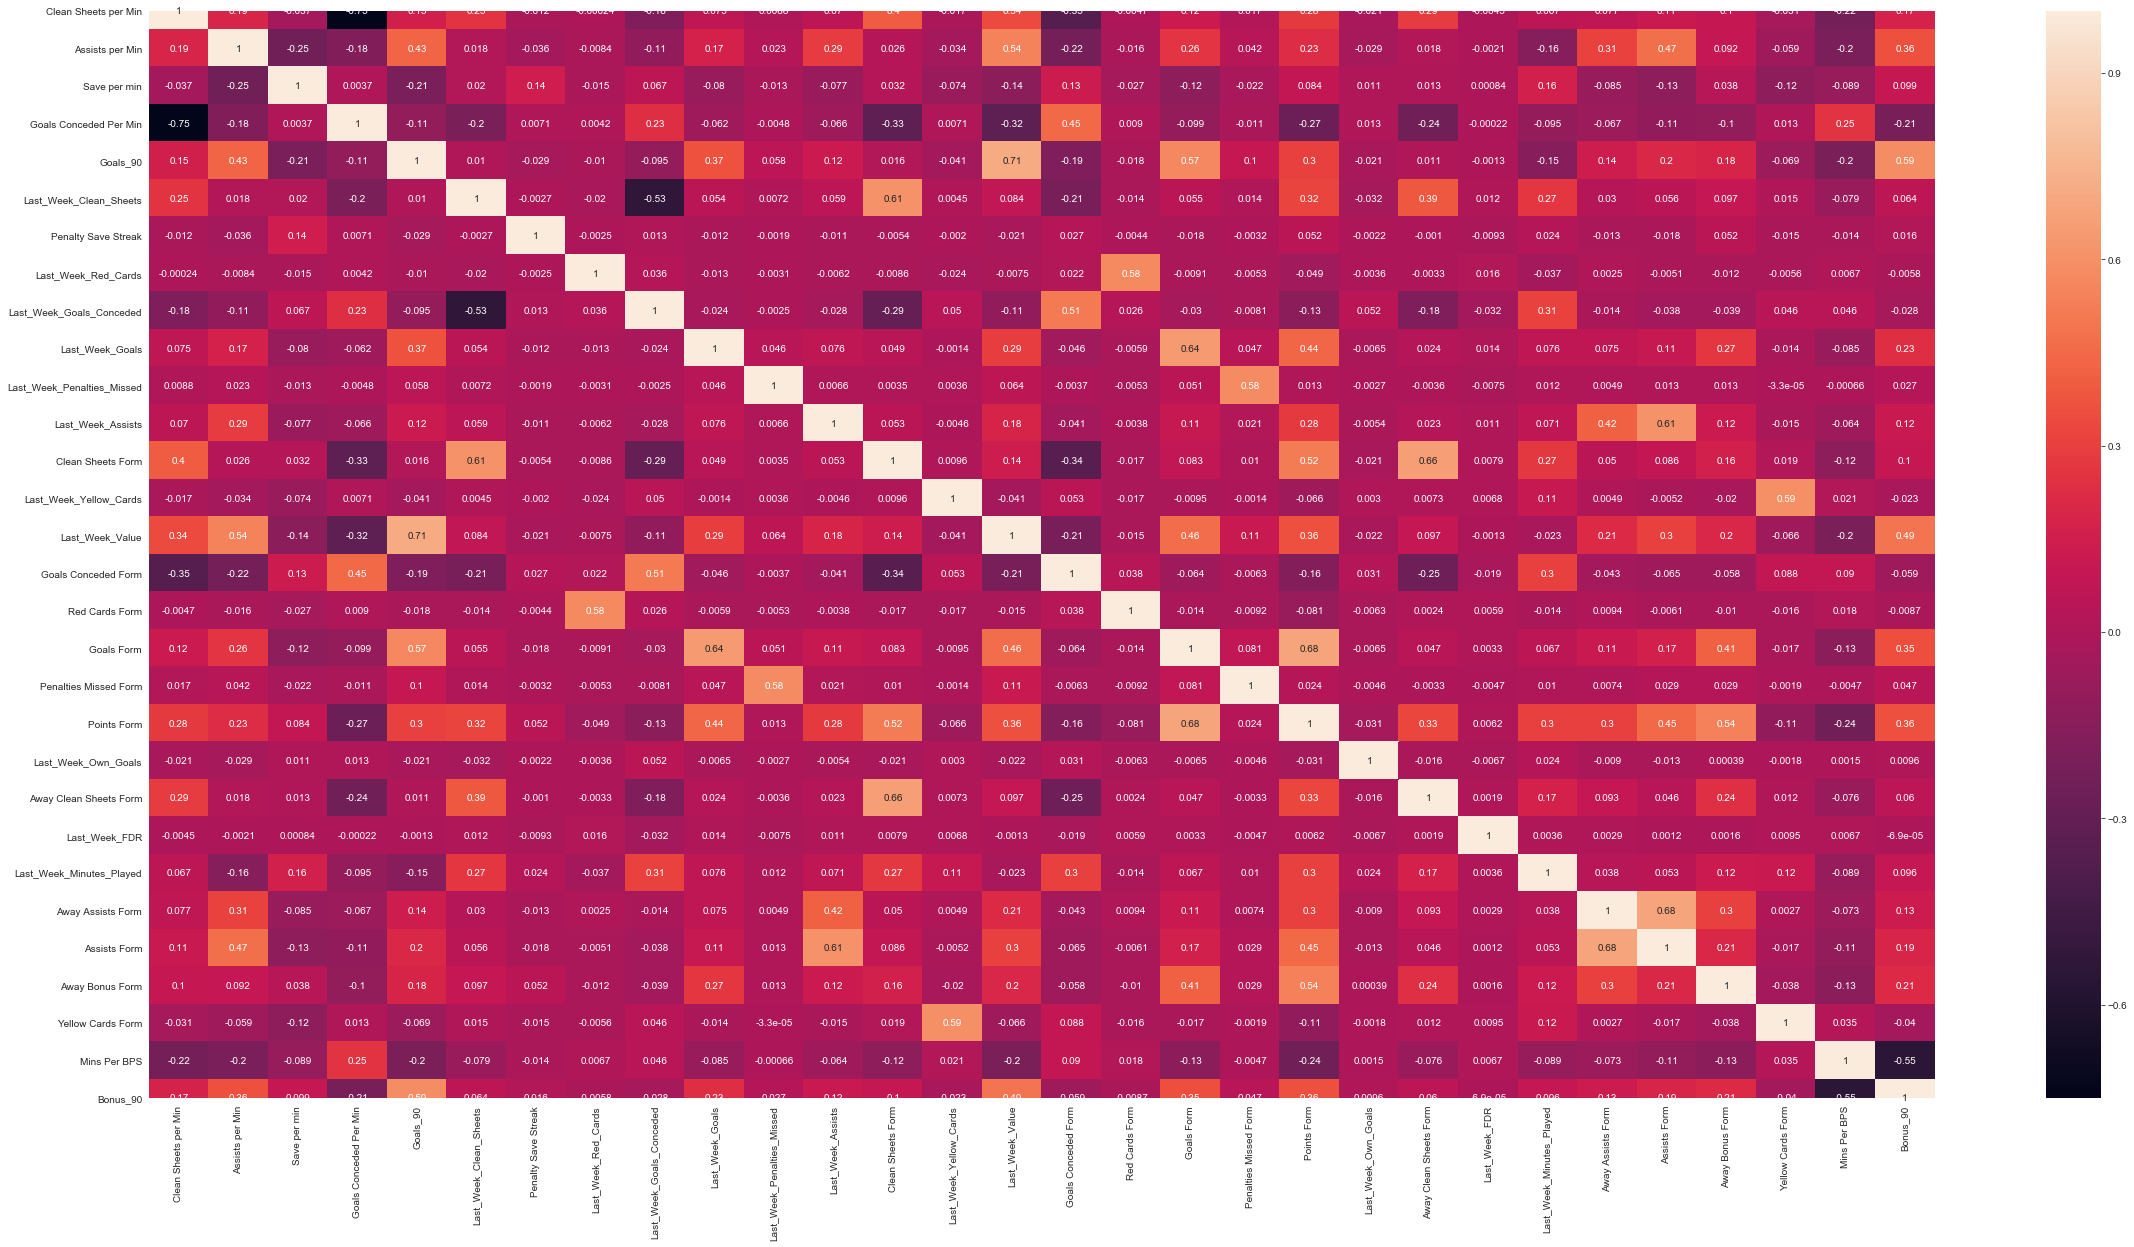

In [71]:
# from imblearn.oversampling import SMOTE
X1=gws1[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
#X1=gws1[['Away ICT Form','Home ICT Form','Goals Conceded Form','Points Form','Bonus_90','Home Assists Form','Away Assists Form','Clean Sheets per Min','Assists per Min','Goals Conceded Per Min','Save per min','Last_Week_Penalties_Missed','Goals_90','Penalty Save Streak','Last_Week_Red_Cards','Penalties Missed Form','Last_Week_Own_Goals', 'Last_Week_Value','Clean Sheet Streak','Goal Streak','Goals Form','Red Cards Form']]
y1=y.astype(int)
plt.figure(figsize=(40,20))
sns.heatmap(X1.corr(),annot=True)


**We have divided the datastet into training and testing set using a 80/20 split.** 

In [58]:
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.20, random_state=150)


**We cannot comapre apples ot oranges in the same way we cannot compare goals scored to goals saved. In order for everything to be comaprable we have scaled the values using a minmaxscaler**

In [59]:
scaler= MinMaxScaler(feature_range=(0, 1), copy=True)
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)




**Fitting the algorithm with tuned hyperparameters**

In [62]:

ovr=RandomForestClassifier(max_depth= 11, min_samples_leaf= 3,n_estimators=300, class_weight='balanced',max_features='sqrt',bootstrap=True)
ovr.fit(X_train, y_train)




RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

**Once the model is trained, we predict output for testing set. Going a step further we can also see how sure the algorithm was before it made a decision by plotting probablities**

In [63]:
from sklearn.metrics import roc_curve
predict=ovr.predict(X_test)
predictp=ovr.predict_proba(X_test)


**Storing the output as well as the probabilities for each prediction in a dataframe**

In [64]:
df1=pd.DataFrame({'Actual':y_test,'Predicted':predict})
a=df1[1]=predictp[:,0].round(decimals=2)
b=df1[2]=predictp[:,1].round(decimals=2)


df1.head(40)


,Actual,Predicted,1,2
62095,0,0,0.51,0.49
42953,0,0,0.86,0.14
45403,0,0,0.63,0.37
58533,0,0,0.69,0.31
64847,0,0,0.59,0.41
52705,0,0,0.67,0.33
57639,0,1,0.44,0.56
64726,0,0,0.63,0.37
10267,0,0,0.99,0.01
86591,0,0,0.74,0.26


**Performance Metrics of the Model**

In [70]:
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
from sklearn.metrics import precision_score

print(classification_report(y_test,predict))
print("Balanced Accuracy : ",balanced_accuracy_score(y_test,predict))
print("Confusion Matrix : \n", confusion_matrix(y_test,predict))
print("Model Score : ",ovr.score(X_test,y_test))



              precision    recall  f1-score   support

           0       0.94      0.84      0.88      6600
           1       0.21      0.44      0.28       647

    accuracy                           0.80      7247
   macro avg       0.57      0.64      0.58      7247
weighted avg       0.87      0.80      0.83      7247

Balanced Accuracy :  0.6389746381902487
Confusion Matrix : 
 [[5517 1083]
 [ 361  286]]
Model Score :  0.800745135918311


**We achieved a balanced accuracy of 64%. There is a lot of work that still needs to be done improve the metrics for the minority class**


**Validation on unseen data. We try to predict scores for the upcoming week. We will be performing same set of pre processing on this dataset to make it consistent with the data on which the data was trained**

In [212]:
conn = sqlite3.connect("/Users/anmolsabharwal/Desktop/FPL1.db")
cur = conn.cursor()
x= pd.read_sql_query("SELECT * FROM test", conn)
x.tail()
x = x.replace(r'^\s*$', np.NaN, regex=True)
x.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'gw'],
      dtype='object')

In [213]:
x=x.astype({'assists':float})
x=x.astype({'bonus':float})
x=x.astype({'bps':float})
x=x.astype({'clean_sheets':float})
x=x.astype({'creativity':float})
x=x.astype({'element':float})
x=x.astype({'fixture':float})
x=x.astype({'goals_conceded':float})
x=x.astype({'goals_scored':float})
x=x.astype({'ict_index':float})
x=x.astype({'influence':float})
x=x.astype({'minutes':float})
x=x.astype({'opponent_team':float})
x=x.astype({'own_goals':float})
x=x.astype({'penalties_missed':float})
x=x.astype({'penalties_saved':float})
x=x.astype({'red_cards':float})
x=x.astype({'round':float})
x=x.astype({'selected':float})
x=x.astype({'team_a_score':float})
x=x.astype({'team_h_score':float})
x=x.astype({'threat':float})
x=x.astype({'total_points':float})
x=x.astype({'transfers_balance':float})
x=x.astype({'value':float})
x=x.astype({'yellow_cards':float})






In [214]:
x = x.assign(id=(x['name']).astype('category').cat.codes)


In [215]:
x.rename(columns={'opponent_team':'fdr'},inplace=True)


In [216]:
x['fdr']=x['fdr'].apply(fd).astype(float)


In [217]:
x['kickoff_time']=pd.to_datetime(x['kickoff_time'])

In [218]:
x['kickoff_time'] = x.kickoff_time.dt.hour

In [219]:
x['kickoff_time']=x['kickoff_time'].apply(time).astype(float)
x.tail(20)

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id
89138,Neco Williams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,1054
89139,Abd-Al-Ali Morakinyo Olaposi Koiki,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,150,8
89140,John Ruddy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,695
89141,Oriol Romeu Vidal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,150,1090
89142,Aaron Wan-Bissaka,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,7
89143,JoseÃÅ Ignacio Peleteiro Romallo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,740
89144,Ryan Fraser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,1206
89145,Robert Elliot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,150,1175
89146,Craig Cathcart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,150,285
89147,Kevin Danso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,150,805


In [220]:
x['home']=x['was_home'].apply(was_home)
x.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id,home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,454.0,10.0,0.0,0.0,...,0.0,0.0,0,0,55.0,FALSE,0.0,1,1,Away
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,142.0,3.0,0.0,0.0,...,1.0,0.0,0,0,60.0,TRUE,0.0,1,2,Home
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,16.0,8.0,3.0,0.0,...,2.0,0.0,0,0,80.0,TRUE,0.0,1,5,Home
3,Abdoulaye Doucoure,0.0,0.0,0.0,0.0,0.0,482.0,7.0,0.0,0.0,...,0.0,0.0,0,0,50.0,FALSE,0.0,1,10,Away
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,80.0,10.0,0.0,0.0,...,0.0,0.0,0,0,55.0,TRUE,0.0,1,12,Home


In [221]:
x['Away Points'] = np.where(x['home'] == 'Home', x['total_points'] * 0,x['total_points'])
x['Home Points'] = np.where(x['home'] == 'Away', x['total_points'] * 0,x['total_points'])

x['Away Influence'] = np.where(x['home'] == 'Home', x['influence'] * 0,x['influence'])
x['Home Influence'] = np.where(x['home'] == 'Away', x['influence'] * 0,x['influence'])

x['Away Goals'] = np.where(x['home'] == 'Home', x['goals_scored'] * 0,x['goals_scored'])
x['Home Goals'] = np.where(x['home'] == 'Away', x['goals_scored'] * 0,x['goals_scored'])

x['Away Saves'] = np.where(x['home'] == 'Home', x['saves'] * 0,x['saves'])
x['Home Saves'] = np.where(x['home'] == 'Away', x['saves'] * 0,x['saves'])

x['Away Creativity'] = np.where(x['home'] == 'Home', x['creativity'] * 0,x['creativity'])
x['Home Creativity'] = np.where(x['home'] == 'Away', x['creativity'] * 0,x['creativity'])

x['Away ICT'] = np.where(x['home'] == 'Home', x['ict_index'] * 0,x['ict_index'])
x['Home ICT'] = np.where(x['home'] == 'Away', x['ict_index'] * 0,x['ict_index'])

x['Away Bonus'] = np.where(x['home'] == 'Home', x['bonus'] * 0,x['bonus'])
x['Home Bonus'] = np.where(x['home'] == 'Away', x['bonus'] * 0,x['bonus'])

x['Away Clean Sheets'] = np.where(x['home'] == 'Home', x['clean_sheets'] * 0,x['clean_sheets'])
x['Home Clean Sheets'] = np.where(x['home'] == 'Away', x['clean_sheets'] * 0,x['clean_sheets'])

x['Away Penalties Saved'] = np.where(x['home'] == 'Home', x['penalties_saved'] * 0,x['penalties_saved'])
x['Home Penalties Saved'] = np.where(x['home'] == 'Away', x['penalties_saved'] * 0,x['penalties_saved'])

x['Away Goals Conceded'] = np.where(x['home'] == 'Home', x['goals_conceded'] * 0,x['goals_conceded'])
x['Home Goals Conceded'] = np.where(x['home'] == 'Away', x['goals_conceded'] * 0,x['goals_conceded'])

x['Away Assists'] = np.where(x['home'] == 'Home', x['assists'] * 0,x['assists'])
x['Home Assists'] = np.where(x['home'] == 'Away', x['assists'] * 0,x['assists'])

x.tail(100)


,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,Away Bonus,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89063,Christian Fuchs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89064,Mark Duffy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89065,Marco Stiepermann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89066,Todd Cantwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89067,Matteo Darmian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [222]:
x.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [224]:
x['points']=x['total_points'].apply(points)
x.tail(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Home Bonus,Away Clean Sheets,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points
89058,Danny Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89059,Ryan Giles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89060,Moussa Djenepo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89061,Alex Iwobi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89062,Mason Greenwood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89063,Christian Fuchs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89064,Mark Duffy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89065,Marco Stiepermann,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89066,Todd Cantwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
89067,Matteo Darmian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [225]:
home=pd.get_dummies(x['home'])
x=pd.concat([x,home],axis=1)
x.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Home Clean Sheets,Away Penalties Saved,Home Penalties Saved,Away Goals Conceded,Home Goals Conceded,Away Assists,Home Assists,points,Away,Home
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0,0,1
3,Abdoulaye Doucoure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
5,Abel Hernandez,1.0,0.0,10.0,0.0,12.2,1.0,0.0,5.7,14.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,0,1
6,Adama Diomande,0.0,2.0,29.0,0.0,16.8,1.0,1.0,10.7,45.2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1
7,Adam Clayton,0.0,0.0,6.0,0.0,2.2,1.0,0.0,1.4,3.2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1
8,Adam Federici,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
9,Adam Forshaw,0.0,0.0,3.0,0.0,1.3,1.0,0.0,0.3,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1


In [226]:
x['Last_Week_Points'] = x.groupby(['id'])['points'].shift().astype(float)
# x['Last_2_Week_Points'] = x.groupby(['id'])['points'].shift(2).astype(float)
#x['Last_3_Week_Points'] = x.groupby(['id'])['total_points'].shift(3).astype(float)
#x['Last_4_Week_Points'] = x.groupby(['id'])['total_points'].shift(4).astype(float)



x['Last_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift().astype(float)
# x['Last_2_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(2).astype(float)
#x['Last_3_Week_Goals'] = x.groupby(['id'])['goals_scored'].shift(3).astype(float)


x['Last_Week_ICT'] = x.groupby(['id'])['ict_index'].shift().astype(float)
x['Last_2_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(2).astype(float)
# #x['Last_3_Week_ICT'] = x.groupby(['id'])['ict_index'].shift(3).astype(float)


x['Last_Week_BPS'] = x.groupby(['id'])['bps'].shift().astype(float)
x['Last_2_Week_BPS'] = x.groupby(['id'])['bps'].shift(2).astype(float)
#x['Last_3_Week_BPS'] = x.groupby(['id'])['bps'].shift(3).astype(float)


x['Last_Week_Assists'] = x.groupby(['id'])['assists'].shift().astype(float)
x['Last_2_Week_Assists'] = x.groupby(['id'])['assists'].shift(2).astype(float)
#x['Last_3_Week_Assists'] = x.groupby(['id'])['assists'].shift(3).astype(float)


x['Last_Week_Bonus'] = x.groupby(['id'])['bonus'].shift().astype(float)
x['Last_2_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(2).astype(float)
#x['Last_3_Week_Bonus'] = x.groupby(['id'])['bonus'].shift(3).astype(float)


x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)
x['Last_2_Week_Penalties_Saved'] =x.groupby(['id'])['penalties_saved'].shift(2).astype(float)


x['Last_Week_Influence'] = x.groupby(['id'])['influence'].shift().astype(float)
x['Last_2_Week_Influence'] = x.groupby(['id'])['influence'].shift(2).astype(float)
#x['Last_3_Week_Influence'] = x.groupby(['id'])['influence'].shift(3).astype(float)


x['Last_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift().astype(float)
x['Last_2_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(2).astype(float)
#x['Last_3_Week_Minutes_Played'] = x.groupby(['id'])['minutes'].shift(3).astype(float)


x['Last_Week_Threat'] = x.groupby(['id'])['threat'].shift().astype(float)
x['Last_2_Week_Threat'] = x.groupby(['id'])['threat'].shift(2).astype(float)
# #x['Last_3_Week_Threat'] = x.groupby(['id'])['threat'].shift(3).astype(float)


x['Last_Week_Selected'] = x.groupby(['id'])['selected'].shift().astype(float)
x['Last_2_Week_Selected'] = x.groupby(['id'])['selected'].shift(2).astype(float)
#x['Last_3_Week_Selected'] = x.groupby(['id'])['selected'].shift(3).astype(float)


x['Last_Week_Value'] = x.groupby(['id'])['value'].shift().astype(float)
x['Last_2_Week_Value'] = x.groupby(['id'])['value'].shift(2).astype(float)
# x['Last_3_Week_Value'] = x.groupby(['id'])['value'].shift(3).astype(float)


x['Last_Week_Creativity'] = x.groupby(['id'])['creativity'].shift().astype(float)
x['Last_2_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(2).astype(float)
# #x['Last_3_Week_Creativity'] = x.groupby(['id'])['creativity'].shift(3).astype(float)



x['Last_Week_FDR'] = x.groupby(['id'])['fdr'].shift().astype(float).astype(float)
x['Last_2_Week_FDR'] = x.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
x['Last_3_Week_FDR'] = x.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


x['Last_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift().astype(float)
x['Last_2_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#x['Last_3_Week_Clean_Sheets'] = x.groupby(['id'])['clean_sheets'].shift(3).astype(float)


x['Last_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift().astype(float)
x['Last_2_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#x['Last_3_Week_Goals_Conceded'] = x.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# x['Last_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift().astype(float)
# x['Last_2_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# x['Last_3_Week_Kickoff_Time'] = x.groupby(['id'])['kickoff_time'].shift(3).astype(float)


x['Last_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift().astype(float)
x['Last_2_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(2).astype(float)
# x['Last_3_Week_Own_Goals'] = x.groupby(['id'])['own_goals'].shift(3).astype(float)

x['Last_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift().astype(float)

x['Last_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift().astype(float)
x['Last_2_Week_Penalties_Missed'] = x.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# x['Last_3_Week_Penalties_Saved'] = x.groupby(['id'])['penalties_saved'].shift(3).astype(float)


x['Last_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift().astype(float)
x['Last_2_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(2).astype(float)
# x['Last_3_Week_Red_Cards'] = x.groupby(['id'])['red_cards'].shift(3).astype(float)


x['Last_Week_Saves'] = x.groupby(['id'])['saves'].shift().astype(float)
x['Last_2_Week_Saves'] = x.groupby(['id'])['saves'].shift(2).astype(float)
#x['Last_3_Week_Saves'] = x.groupby(['id'])['saves'].shift(3)


x['Last_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift().astype(float)
x['Last_2_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(2).astype(float)
# x['Last_3_Week_Yellow_Cards'] = x.groupby(['id'])['yellow_cards'].shift(3)


# x['Last_Week_Home'] = x.groupby(['id'])['home'].shift()
# x['Last_2_Week_Home'] = x.groupby(['id'])['home'].shift(2)
# x['Last_3_Week_Home'] = x.groupby(['id'])['home'].shift(3)
#feature engineered a number of variables to better define the dependent variable
window=3

hpm =x.groupby('id',as_index=False)['Home Points'].rolling(window=window).sum().shift(1).astype(float)
x["Home Points Form"] = hpm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['Away Points'].rolling(window=window).sum().shift(1).astype(float)
x["Away Points Form"] = apm.reset_index(level=0, drop=True)

ppm =(x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =(x.groupby('id',as_index=False)['value'].expanding().sum()/x.groupby('id',as_index=False)['total_points'].expanding().sum()*90).astype(float)
x["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =x.groupby('id',as_index=False)['assists'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Assists per Min"] = apm.reset_index(level=0, drop=True)

gpm =(x.groupby('id',as_index=False)['goals_scored'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =(x.groupby('id',as_index=False)['influence'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =(x.groupby('id',as_index=False)['bonus'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum()*90).astype(float)
x["Bonus_90"] = ipm.reset_index(level=0, drop=True)

ih =x.groupby(['id','name'],as_index=False)['Home Influence'].rolling(window=window).sum().shift(1).astype(float)
x["Home Influence Form"] = ih.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['Away Influence'].rolling(window=window).sum().shift(1).astype(float)
x["Away Influence Form"] = ah.reset_index(level=0, drop=True)

hg =x.groupby('id',as_index=False)['Home Goals'].rolling(window=window).sum().shift(1).astype(float)
x["Home Goals Form"] = hg.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['Away Goals'].rolling(window=window).sum().shift(1).astype(float)
x["Away Goals Form"] = hg.reset_index(level=0, drop=True)


gs =x.groupby('id',as_index=False)['goals_scored'].rolling(window=window).sum().shift(1).astype(float)
x["Goals Form"] = gs.reset_index(level=0, drop=True)

ag =x.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Clean Sheets per Min"] = ag.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['total_points'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Points Per Min"] = cs.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Goals Conceded Per Min"] = gc.reset_index(level=0, drop=True)

s =x.groupby('id',as_index=False)['saves'].expanding().sum()/x.groupby('id',as_index=False)['minutes'].expanding().sum().astype(float)
x["Save per min"] = s.reset_index(level=0, drop=True)

sh =x.groupby('id',as_index=False)['Home Saves'].rolling(window=window).sum().shift(1).astype(float)
x["Home Saves Form"] = sh.reset_index(level=0, drop=True)

sa =x.groupby('id',as_index=False)['Away Saves'].rolling(window=window).sum().shift(1).astype(float)
x["Away Saves Form"] = sa.reset_index(level=0, drop=True)

sf =x.groupby('id',as_index=False)['saves'].rolling(window=window).sum().shift(1).astype(float)
x["Saves Form"] = sf.reset_index(level=0, drop=True)

mp =x.groupby('id',as_index=False)['minutes'].rolling(window=window).sum().shift(1).astype(float)
x["Minutes Form"] = mp.reset_index(level=0, drop=True)

ch =x.groupby('id',as_index=False)['Home Creativity'].rolling(window=window).sum().shift(1).astype(float)
x["Home Creativity Form"] = ch.reset_index(level=0, drop=True)

ca =x.groupby('id',as_index=False)['Away Creativity'].rolling(window=window).sum().shift(1).astype(float)
x["Away Creativity Form"] = ca.reset_index(level=0, drop=True)

csh =x.groupby('id',as_index=False)['Home Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
x[" Home Clean Sheets Form"] = csh.reset_index(level=0, drop=True)

csa =x.groupby('id',as_index=False)['Away Clean Sheets'].rolling(window=window).sum().shift(1).astype(float)
x["Away Clean Sheets Form"] = csa.reset_index(level=0, drop=True)

cs =x.groupby('id',as_index=False)['clean_sheets'].rolling(window=window).sum().shift(1).astype(float)
x["Clean Sheets Form"] = cs.reset_index(level=0, drop=True)

bph =x.groupby('id',as_index=False)['Home Bonus'].rolling(window=window).sum().shift(1).astype(float)
x['Home Bonus Form'] = bph.reset_index(level=0, drop=True)

bp =x.groupby('id',as_index=False)['bonus'].rolling(window=window).sum().shift(1).astype(float)
x['Bonus Form'] = bp.reset_index(level=0, drop=True)

bpa =x.groupby('id',as_index=False)['Away Bonus'].rolling(window=window).sum().shift(1).astype(float)
x["Away Bonus Form"] = bpa.reset_index(level=0, drop=True)

icth =x.groupby('id',as_index=False)['Home ICT'].rolling(window=window).sum().shift(1).astype(float)
x['Home ICT Form'] = icth.reset_index(level=0, drop=True)

icta =x.groupby('id',as_index=False)['Away ICT'].rolling(window=window).sum().shift(1).astype(float)
x["Away ICT Form"] = icta.reset_index(level=0, drop=True)


ict =x.groupby('id',as_index=False)['ict_index'].rolling(window=window).sum().shift(1).astype(float)
x["ICT Form"] = ict.reset_index(level=0, drop=True)

ah =x.groupby('id',as_index=False)['Home Assists'].rolling(window=window).sum().shift(1).astype(float)
x['Home Assists Form'] = ah.reset_index(level=0, drop=True)

aa =x.groupby('id',as_index=False)['Away Assists'].rolling(window=window).sum().shift(1).astype(float)
x["Away Assists Form"] = aa.reset_index(level=0, drop=True)

ast =x.groupby('id',as_index=False)['assists'].rolling(window=window).sum().shift(1).astype(float)
x["Assists Form"] = ast.reset_index(level=0, drop=True)

# ms =x.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

gca =x.groupby('id',as_index=False)['Away Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Away Goals Concecded Form"] = gca.reset_index(level=0, drop=True)

gch =x.groupby('id',as_index=False)['Home Goals Conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gc =x.groupby('id',as_index=False)['goals_conceded'].rolling(window=5).sum().shift(1).astype(float)
x["Goals Conceded Form"] = gc.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)

tp =x.groupby('id',as_index=False)['total_points'].rolling(window=window).sum().shift(1).astype(float)
x["Points Form"] = tp.reset_index(level=0, drop=True)

pm =x.groupby('id',as_index=False)['penalties_missed'].rolling(window=window).sum().shift(1).astype(float)
x["Penalties Missed Form"] = pm.reset_index(level=0, drop=True)

yc =x.groupby('id',as_index=False)['yellow_cards'].rolling(window=window).sum().shift(1).astype(float)
x["Yellow Cards Form"] = yc.reset_index(level=0, drop=True)

rc =x.groupby('id',as_index=False)['red_cards'].rolling(window=window).sum().shift(1).astype(float)
x["Red Cards Form"] = rc.reset_index(level=0, drop=True)
# ms =x1.groupby('id',as_index=False)['minutes'+0.0000001].expanding().sum()/x1.groupby('id',as_index=False)['saves'+0.0000001].expanding().sum()
# x1["Mins Per Save"] = ms.reset_index(level=0, drop=True)

bpss =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['bps'].expanding().sum().astype(float)
x["Mins Per BPS"] = bpss.reset_index(level=0, drop=True)

# gca =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Away'].expanding().sum().astype(float)
# x["Goals Concecded Away"] = gca.reset_index(level=0, drop=True)

# gch =x.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/x.groupby('id',as_index=False)['Home'].expanding().sum().astype(float)
# x["Goals Conceded Home"] = gch.reset_index(level=0, drop=True)

gcm =x.groupby('id',as_index=False)['minutes'].expanding().sum()/x.groupby('id',as_index=False)['goals_conceded'].expanding().sum().astype(float)
x["Mins per Goals Conceded"] = gcm.reset_index(level=0, drop=True)




In [227]:
dx=x.groupby('id').apply(f)
x=x.groupby('id').apply(f2)
x=x.groupby('id').apply(f3)
x.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,...,Away Goals Concecded Form,Goals Conceded Home,Goals Conceded Form,Mins per Goals Conceded,Points Form,Penalties Missed Form,Yellow Cards Form,Red Cards Form,Clean Sheet Streak,Penalty Save Streak
0,Aaron Cresswell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,0.0,0.0,6.0,0.0,0.3,0.0,0.0,0.9,8.2,...,NaN,NaN,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0.0,0.0,5.0,0.0,4.9,3.0,0.0,3.0,2.2,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucoure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,Abdul Rahman Baba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**We seperate gameweek 150 from the rest of the data because we will be predicitng scores for that gameweek.**

In [229]:
x1=x[x['gw']=='150']
x1
x_test=x1[['Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_test=x_test.replace([np.inf, -np.inf], np.nan)
x_test=x_test.dropna()
x_test

,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,...,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90
88504,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.323636,22.604508
88505,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,76.0,1.0,1.0,1.0,0.0,5.393405,17.795088
88506,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.065868,15.791489
88507,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2.0,83.0,1.0,4.0,3.0,0.0,2.917722,48.201735
88510,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.989362,27.947294
88511,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,...,0.0,1.0,2.0,90.0,1.0,4.0,0.0,0.0,4.469439,28.310729
88512,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.255639,12.688525
88513,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000,17.142857
88514,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,3.0,74.0,0.0,0.0,0.0,2.0,5.318993,22.916354
88516,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.600000,4.406250


In [230]:
x_testf=x1[['name','Clean Sheets per Min', 'Assists per Min', 'Save per min','Goals Conceded Per Min', 'Goals_90', 'Last_Week_Clean_Sheets', 'Penalty Save Streak', 'Last_Week_Red_Cards','Last_Week_Goals_Conceded','Last_Week_Goals','Last_Week_Penalties_Missed','Last_Week_Assists','Clean Sheets Form','Last_Week_Yellow_Cards','Last_Week_Value','Goals Conceded Form','Red Cards Form', 'Goals Form','Penalties Missed Form','Points Form','Last_Week_Own_Goals','Away Clean Sheets Form','Last_Week_FDR','Last_Week_Minutes_Played','Away Assists Form','Assists Form','Away Bonus Form','Yellow Cards Form','Mins Per BPS','Bonus_90']]
x_testf=x_testf.replace([np.inf, -np.inf], np.nan)
x_testf=x_testf.dropna()
x_test.head(100)


,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,Last_Week_Goals,...,Last_Week_Own_Goals,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90
88504,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.323636,22.604508
88505,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,76.0,1.0,1.0,1.0,0.0,5.393405,17.795088
88506,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.065868,15.791489
88507,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,2.0,83.0,1.0,4.0,3.0,0.0,2.917722,48.201735
88510,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.989362,27.947294
88511,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,1.0,...,0.0,1.0,2.0,90.0,1.0,4.0,0.0,0.0,4.469439,28.310729
88512,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.255639,12.688525
88513,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000,17.142857
88514,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,3.0,74.0,0.0,0.0,0.0,2.0,5.318993,22.916354
88516,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.600000,4.406250


In [231]:
x_test1=scaler.transform(x_test)
predict1=ovr.predict(x_test1)
predict1

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [237]:
predict1=pd.DataFrame(predict1)
predict1.head(100)
df1 = pd.concat([x_testf.reset_index(drop='True'),predict1.reset_index(drop='True')],axis=1)
df1.rename(columns={0:'Prediciton'},inplace=True)
df1.head(100)


,name,Clean Sheets per Min,Assists per Min,Save per min,Goals Conceded Per Min,Goals_90,Last_Week_Clean_Sheets,Penalty Save Streak,Last_Week_Red_Cards,Last_Week_Goals_Conceded,...,Away Clean Sheets Form,Last_Week_FDR,Last_Week_Minutes_Played,Away Assists Form,Assists Form,Away Bonus Form,Yellow Cards Form,Mins Per BPS,Bonus_90,Prediciton
0,Charlie Austin,0.005123,0.001366,0.000000,0.013661,0.461066,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.323636,22.604508,0
1,Mark Noble,0.003057,0.000843,0.000000,0.016549,0.151787,1.0,0.0,0.0,0.0,...,1.0,1.0,76.0,1.0,1.0,1.0,0.0,5.393405,17.795088,0
2,Simon Mignolet,0.003783,0.000000,0.020804,0.012766,0.000000,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.065868,15.791489,0
3,Bruno Miguel Borges Fernandes,0.007592,0.007592,0.000000,0.005423,0.683297,0.0,0.0,0.0,1.0,...,1.0,2.0,83.0,1.0,4.0,3.0,0.0,2.917722,48.201735,1
4,Laurent Koscielny,0.003451,0.000157,0.000000,0.014431,0.098824,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.989362,27.947294,0
5,Anthony Martial,0.004934,0.003243,0.000000,0.010856,0.494854,0.0,0.0,0.0,2.0,...,1.0,2.0,90.0,1.0,4.0,0.0,0.0,4.469439,28.310729,1
6,Isaac Success Ajayi,0.001821,0.000911,0.000000,0.021858,0.081967,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.255639,12.688525,0
7,Marc Navarro,0.000000,0.000000,0.000000,0.035714,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.000000,17.142857,0
8,Luka Milivojevic,0.003156,0.000493,0.000000,0.015486,0.239692,0.0,0.0,0.0,2.0,...,0.0,3.0,74.0,0.0,0.0,0.0,2.0,5.318993,22.916354,0
9,Beni Baningime,0.000000,0.000000,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.600000,4.406250,0


In [238]:
df1.to_sql('Predictions', conn, if_exists='replace', index=False)